In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from typing import *
from sensetools.plots import feature_labeller

In [53]:
protein = '1fme'
lag = 41
md_t2 = {'1fme': 18*1000}


In [113]:
summary_path = f'{protein}/summary.h5'

selection = pd.read_hdf(summary_path, key='model_selection')
timescales = pd.read_hdf(summary_path, key='timescales')
vamps = pd.read_hdf(summary_path, key='vamps')
gaps = pd.read_hdf(summary_path, key='timescale_ratio')
gaps.reset_index(inplace=True)
timescales.reset_index(inplace=True)
vamps.reset_index(inplace=True)

vamps = vamps.loc[vamps.lag==lag, :]
timescales = timescales.loc[timescales.lag==lag, :]

hp_samples = pd.read_hdf('../data/msms/hpsample.h5')

hp_samples.reset_index(inplace=True)

hp_samples['feature'] = hp_samples.apply(feature_labeller, axis=1)
vamps = vamps.merge(hp_samples.loc[:, ['feature', 'hp_ix', 'tica__dim', 'tica__lag', 'cluster__k']], on='hp_ix')
vamps['median_loss'] = 100*(-vamps['median'] + vamps['process'])/vamps['process']
vamps['lb_loss'] = 100*(-vamps['lb'] + vamps['process'])/vamps['process']
vamps['ub_loss'] = 100*(-vamps['ub'] + vamps['process'])/vamps['process']

In [114]:
df = vamps.merge(timescales, on=['hp_ix', 'lag', 'count'], suffixes=['_vamp', '_ts'])


In [115]:
cols_by_feature = {'dihed.': 0, 'dist.': 1, 'logit(dist.)': 1}

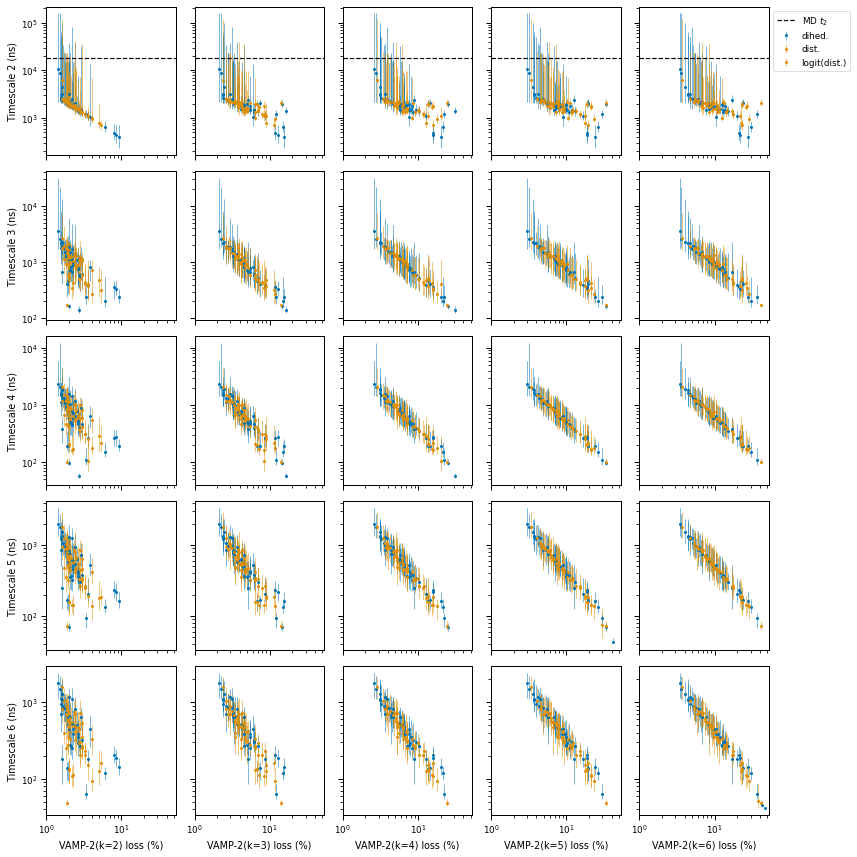

In [116]:
with sns.plotting_context('paper'):
    n_procs = 5
    offset = 2
    procs = np.arange(offset, offset+n_procs+1)
    fig, axes = plt.subplots(n_procs, n_procs, figsize=(12, 12), sharex='col', sharey='row')
    
    cols = sns.color_palette('colorblind')
    
    tmp = df.query(f'process_ts <{n_procs+offset}').query(f'process_vamp < {n_procs+offset}')

    for k, v in tmp.groupby(['process_vamp', 'process_ts', 'feature']): 
        ax = axes[k[1]-offset, k[0]-offset]
        x = v['median_loss']
        xerr = [(x-v['lb_loss']), (v['ub_loss']-x)]

        y = v['median_ts']
        yerr = [(y-v['lb_ts']), (v['ub_ts']-y)]

        ax.errorbar(x=x, y=y, yerr=yerr, alpha=1, ms=2, lw=0, marker='o', 
                    elinewidth=0.5, color=cols[cols_by_feature[k[2]]], label=k[2])
        ax.set_yscale('log')
        ax.set_xscale('log')        

    xlim = ax.get_xlim()
    xlim = [min(xlim[0], 1), xlim[1]]
    for i in range(n_procs): 
        axes[0, i].hlines(md_t2[protein],*xlim, color='k', ls='dashed', label=r'MD $t_{2}$')
        axes[0, i].set_xlim(xlim)

    for i in range(n_procs):
        axes[i, 0].set_ylabel(f'Timescale {i+offset} (ns)')
        axes[-1, i].set_xlabel(f'VAMP-2(k={i+offset}) loss (%)')

    axes[0, -1].legend(bbox_to_anchor=(1, 1),loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{protein}/{protein}_vamp_vs_timescales.pdf', bbox_inches='tight')

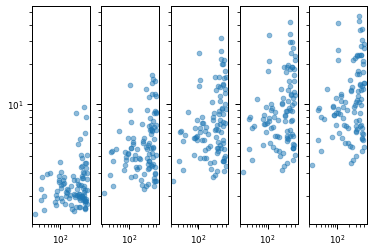

In [119]:
with sns.plotting_context('paper'):
    n_scores = 5
    offset = 2
    
    fig, axes = plt.subplots(1, n_scores, sharex=True, sharey=True)
    tmp = vamps.query(f'process < {n_scores+offset}')
    for k, v in tmp.groupby('process'): 
        ax = axes[k-offset]
        ax.scatter( v['cluster__k'], v['median_loss'],alpha=0.5)
        ax.set_xscale('log')
        ax.set_yscale('log')

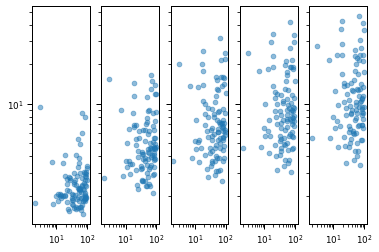

In [121]:
with sns.plotting_context('paper'):
    n_scores = 5
    offset = 2
    
    fig, axes = plt.subplots(1, n_scores, sharex=True, sharey=True)
    tmp = vamps.query(f'process < {n_scores+offset}')
    for k, v in tmp.groupby('process'): 
        ax = axes[k-offset]
        ax.scatter( v['tica__lag'], v['median_loss'], alpha=0.5)
        ax.set_xscale('log')
        ax.set_yscale('log')

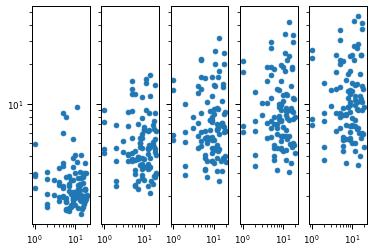

In [123]:
with sns.plotting_context('paper'):
    n_scores = 5
    offset = 2
    
    fig, axes = plt.subplots(1, n_scores, sharex=True, sharey=True)
    tmp = vamps.query(f'process < {n_scores+offset}')
    for k, v in tmp.groupby('process'): 
        ax = axes[k-offset]
        ax.scatter( v['tica__dim'], v['median_loss'])
        ax.set_xscale('log')
        ax.set_yscale('log')